### brunch data learning
* 수집된 following 데이터로 learning을 한다. 

In [1]:
import sqlite3
import pandas as pd
import time
import matplotlib.pylab as plt
import gensim.models.word2vec as word2vec
%matplotlib inline

### brunch data load 
* source : /Users/goodvc/Documents/data/sqllite/brunch_db.db (sqlite DB)

In [11]:
brunch_db_path = '/Users/goodvc/Documents/data/sqllite/brunch_db.db'

In [10]:
def load_all_followings():
    conn = sqlite3.connect(brunch_db_path)
    sql = """ 
    select *  from following_tbl where writerid <> 'brunch';
    """
    ds = pd.read_sql(sql, conn)
    conn.close()
    return ds

### word2vec학스을 위한 corpus 만들기

In [8]:
## corpus generation
## userid = sentence, word = writerid 
from random import shuffle
def makeW2VCorpus(ds):
    uid_grouped = ds[:].groupby('userid')
    corpus = []
    for idx, row in uid_grouped:
        writers = row.writerid.tolist()
        if len(writers) < 2:
            continue
        shuffle(writers)
        corpus.append(writers)

    return corpus

### 만든 corpus로 word2vec  학습

In [14]:
ds = load_all_followings()
corpus = makeW2VCorpus(ds)
b2v = word2vec.Word2Vec(corpus, window=20, size=100, min_count=4)

## sample로 2차원으로 학습

In [12]:
ds = load_all_followings()
corpus = makeW2VCorpus(ds)

In [165]:
b2v_2d = word2vec.Word2Vec(corpus, window=40, size=2, min_count=400)

In [171]:
b2v_3d = word2vec.Word2Vec(corpus, window=30, size=3, min_count=300)

In [133]:
b2v.syn0.shape

(3499, 100)

In [175]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rcParams
from datetime import datetime
import random

import seaborn as sns
#sns.set(style="ticks")
sns.set(style="white")
sns.set(style="darkgrid")

rcParams['font.family'] = 'NanumGothic'
rcParams.update({'font.size': 15})


def drawPlot(v, x, y):
    v.plot(kind='scatter', x=x,y=y, figsize=(18,10), c='r', alpha=0.7)
    for idx, pos in v.iterrows():
        plt.text(pos[x], pos[y], idx, fontdict=dict(alpha=0.7) )
    plt.xlabel('Word2Vec 2-dimensional trained by brunch following data', fontsize=15)
    plt.ylabel('')

def draw3DPlot(v, x, y, z):
    fig = plt.figure(figsize=(20,15))
    threedee = fig.gca(projection='3d')
    threedee.scatter(v[x], v[y],v[z] , c='r')
    for idx, pos in v.iterrows():
        threedee.text(pos[x], pos[y],pos[z],  writer_info_dict[idx]['name'] , fontdict=dict(alpha=0.7)  )

In [157]:
writer_info_dict['goodvc78']['name']

'최규민'

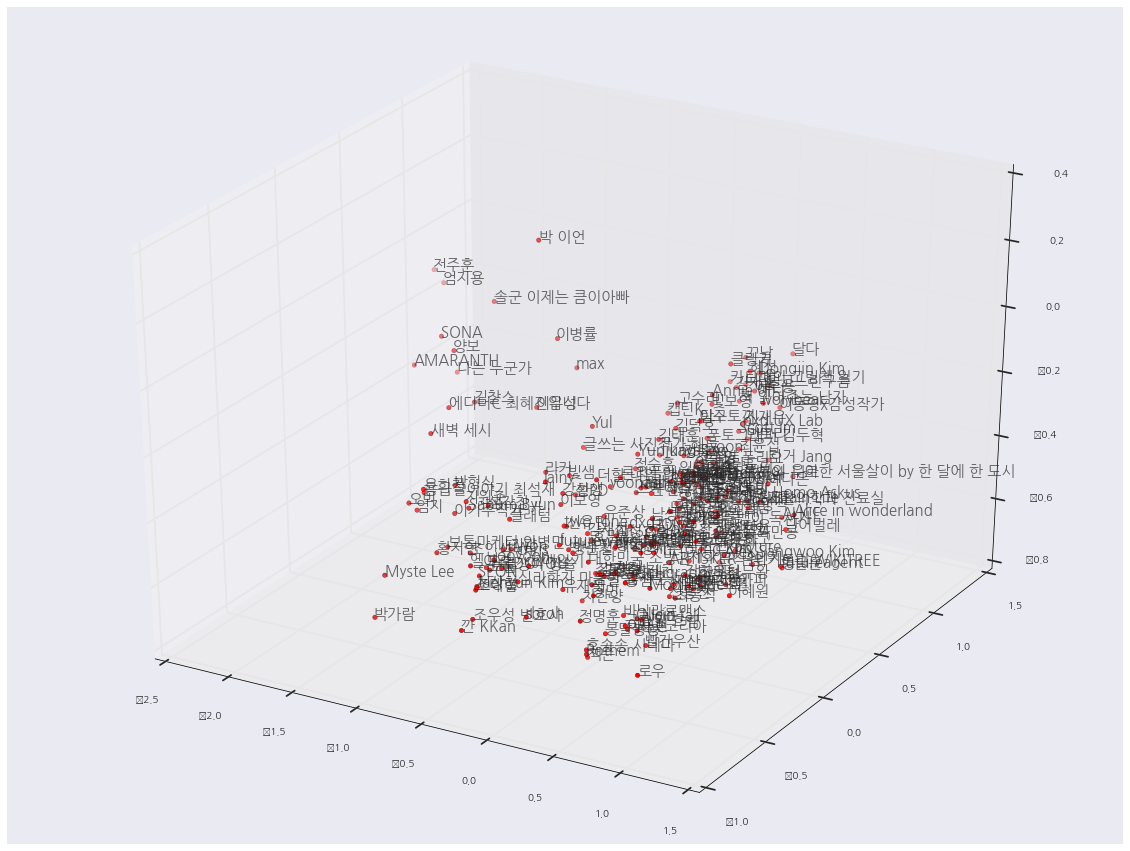

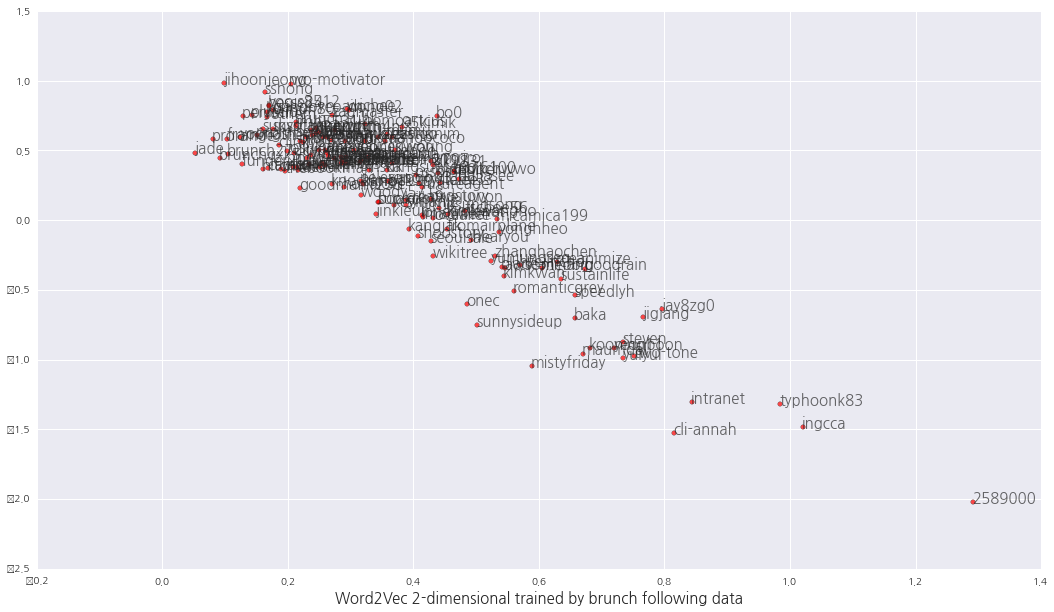

In [176]:
v = pd.DataFrame(b2v_2d.syn0, index=b2v_2d.vocab)
v3 = pd.DataFrame(b2v_3d.syn0, index=b2v_3d.vocab)

draw3DPlot(v3, 0, 1, 2)
drawPlot(v, 0, 1)

In [73]:
ds.count()

idx         333761
userid      333761
writerid    333761
tm          333761
dtype: int64

In [78]:
len(ds.userid.unique())

31989

### writer 정보 dict 데이터 생성

In [144]:
def load_all_writer_info():
    conn = sqlite3.connect(brunch_db_path)
    sql = """ 
    select *  from writer_info_tbl where writerid <> 'brunch';
    """
    ds = pd.read_sql(sql, conn)
    conn.close()
    return ds

In [145]:
def writer_info_ds2dict(ds):
    info_dict = {}
    cols = ['writerid','name','profile','imgsrc','documents','megazines','followers','followings']
    for idx, row in ds.iterrows():
        info_dict[row['writerid']] = { col:row[col] for col in cols }
    return info_dict


In [146]:
writer_info_ds = load_all_writer_info()
writer_info_dict = writer_info_ds2dict(writer_info_ds)

---
## 브런치 추천에 필요한 데이터 저장 

In [3]:
home_dir = '/Users/goodvc/Data/brunch-recsys/resource'

In [41]:
## word2vec model save 
w2v_model_path = '{home}/b2v.20160322.model'.format(home=home_dir)
w2v_model_path = '{home}/b2v.latest.model'.format(home=home_dir)

b2v.save(w2v_model_path)

In [21]:
## writer info dict save to pickle 
import pickle
writer_info_path = '{home}/writer.pkl'.format(home=home_dir)
output = open(writer_info_path, 'wb')
pickle.dump(writer_info_dict, output, 2)
output.close()

In [5]:
b2v = word2vec.Word2Vec.load('{home}/b2v.20160322.model'.format(home=home_dir))

In [6]:
b2v.similarity('goodvc78','suyoung')

0.41305995849092686

In [23]:
def pretty_most_similar(positive=[], negative=[], topn=10):
    nn = b2v.most_similar(positive=positive, negative=negative, topn=topn)    
    for (writer, index) in nn:
        print("https://brunch.co.kr/@{writer}".format(writer=writer) , index)
    return nn

In [26]:
pretty_most_similar(positive=['cojette'],topn=50)

https://brunch.co.kr/@aidenswmo 0.9904768466949463
https://brunch.co.kr/@goodvc78 0.9814918041229248
https://brunch.co.kr/@alden 0.98125821352005
https://brunch.co.kr/@binjis 0.9790887832641602
https://brunch.co.kr/@arawn 0.978187084197998
https://brunch.co.kr/@cailhuiris 0.9781728982925415
https://brunch.co.kr/@jeremycho 0.977438747882843
https://brunch.co.kr/@jeffpaik 0.9772007465362549
https://brunch.co.kr/@sanghwasong 0.9758738279342651
https://brunch.co.kr/@eunwoopark 0.9756622314453125
https://brunch.co.kr/@jounghoyoo 0.9745279550552368
https://brunch.co.kr/@amangkim 0.9744774699211121
https://brunch.co.kr/@logostein 0.9702072143554688
https://brunch.co.kr/@yper 0.9700257778167725
https://brunch.co.kr/@glosh721 0.9699574112892151
https://brunch.co.kr/@jowlee 0.9694841504096985
https://brunch.co.kr/@mushman 0.9693065285682678
https://brunch.co.kr/@yooobing 0.9689971804618835
https://brunch.co.kr/@ajmind 0.9689732193946838
https://brunch.co.kr/@ceo4 0.9686188101768494
https://brunc

[('aidenswmo', 0.9904768466949463),
 ('goodvc78', 0.9814918041229248),
 ('alden', 0.98125821352005),
 ('binjis', 0.9790887832641602),
 ('arawn', 0.978187084197998),
 ('cailhuiris', 0.9781728982925415),
 ('jeremycho', 0.977438747882843),
 ('jeffpaik', 0.9772007465362549),
 ('sanghwasong', 0.9758738279342651),
 ('eunwoopark', 0.9756622314453125),
 ('jounghoyoo', 0.9745279550552368),
 ('amangkim', 0.9744774699211121),
 ('logostein', 0.9702072143554688),
 ('yper', 0.9700257778167725),
 ('glosh721', 0.9699574112892151),
 ('jowlee', 0.9694841504096985),
 ('mushman', 0.9693065285682678),
 ('yooobing', 0.9689971804618835),
 ('ajmind', 0.9689732193946838),
 ('ceo4', 0.9686188101768494),
 ('ryanmoon83', 0.9685822129249573),
 ('brunchjqcb', 0.9673503041267395),
 ('opencommz', 0.9660906791687012),
 ('gisoopa', 0.96485435962677),
 ('kyeongwook-ma', 0.9642015695571899),
 ('troicacho', 0.9639245271682739),
 ('vinnie', 0.9633439779281616),
 ('cjphynmu', 0.9628065824508667),
 ('jaeyeonkim', 0.961920499

In [30]:
pretty_most_similar(positive=['cojette'],topn=50)

https://brunch.co.kr/@aidenswmo 0.9904768466949463
https://brunch.co.kr/@goodvc78 0.9814918041229248
https://brunch.co.kr/@alden 0.98125821352005
https://brunch.co.kr/@binjis 0.9790887832641602
https://brunch.co.kr/@arawn 0.978187084197998
https://brunch.co.kr/@cailhuiris 0.9781728982925415
https://brunch.co.kr/@jeremycho 0.977438747882843
https://brunch.co.kr/@jeffpaik 0.9772007465362549
https://brunch.co.kr/@sanghwasong 0.9758738279342651
https://brunch.co.kr/@eunwoopark 0.9756622314453125
https://brunch.co.kr/@jounghoyoo 0.9745279550552368
https://brunch.co.kr/@amangkim 0.9744774699211121
https://brunch.co.kr/@logostein 0.9702072143554688
https://brunch.co.kr/@yper 0.9700257778167725
https://brunch.co.kr/@glosh721 0.9699574112892151
https://brunch.co.kr/@jowlee 0.9694841504096985
https://brunch.co.kr/@mushman 0.9693065285682678
https://brunch.co.kr/@yooobing 0.9689971804618835
https://brunch.co.kr/@ajmind 0.9689732193946838
https://brunch.co.kr/@ceo4 0.9686188101768494
https://brunc

[('aidenswmo', 0.9904768466949463),
 ('goodvc78', 0.9814918041229248),
 ('alden', 0.98125821352005),
 ('binjis', 0.9790887832641602),
 ('arawn', 0.978187084197998),
 ('cailhuiris', 0.9781728982925415),
 ('jeremycho', 0.977438747882843),
 ('jeffpaik', 0.9772007465362549),
 ('sanghwasong', 0.9758738279342651),
 ('eunwoopark', 0.9756622314453125),
 ('jounghoyoo', 0.9745279550552368),
 ('amangkim', 0.9744774699211121),
 ('logostein', 0.9702072143554688),
 ('yper', 0.9700257778167725),
 ('glosh721', 0.9699574112892151),
 ('jowlee', 0.9694841504096985),
 ('mushman', 0.9693065285682678),
 ('yooobing', 0.9689971804618835),
 ('ajmind', 0.9689732193946838),
 ('ceo4', 0.9686188101768494),
 ('ryanmoon83', 0.9685822129249573),
 ('brunchjqcb', 0.9673503041267395),
 ('opencommz', 0.9660906791687012),
 ('gisoopa', 0.96485435962677),
 ('kyeongwook-ma', 0.9642015695571899),
 ('troicacho', 0.9639245271682739),
 ('vinnie', 0.9633439779281616),
 ('cjphynmu', 0.9628065824508667),
 ('jaeyeonkim', 0.961920499

In [31]:
b2v.syn0.shape

(3499, 100)

### A작가 to Z 작가 
* 작가를 vector의 공간에 embeding을 했기 때문에 
* A작가의 글에서 B작가의 글이 되기 까지 어떤 작가 있는지 확인해 볼수 있을 듯요



In [32]:
goodvc78
paranmoja

NameError: name 'goodvc78' is not defined

In [33]:
from scipy.spatial import distance 
#wv = b2v

#v1 = b2v['goodvc78']
def nestest(NX, v1):
    #writers_vector = wv.syn0  
    dist = distance.cdist( NX, v1.reshape(1,len(v1)), 'cosine' )
    nearest_idx = dist.argmin()
    if (NX[nearest_idx] == v1).all() == True:
        dist[nearest_idx] = 1
        #nearest_idx = dist.argmin()
    #nearest_name = wv.index2word[nearest_idx]
    return nearest_idx

In [34]:
def a2z_writers(w2v, a, z, max_steps=100):
    av = w2v[a]
    zv = w2v[z]
    NX = w2v.syn0

    sv = (zv - av) / max_steps
    exists = set([a,z])
    writers = [a]

    
    for n in range(0,max_steps):
        nv = av+(sv*n)
        idx = nestest(NX, nv)
        name = w2v.index2word[idx]
        if not name in exists :
            #print( "https://brunch.co.kr/@{id}".format(id= w2v.index2word[idx]) )
            writers.append(name)
        exists.add(name)
    writers.append(z)
    return writers
    
writers = a2z_writers( b2v, 'goodvc78', 'paranmoja', 100)

for n in writers:
    print( "https://brunch.co.kr/@{id}".format(id= n) )

https://brunch.co.kr/@goodvc78
https://brunch.co.kr/@joonomics
https://brunch.co.kr/@mongmong
https://brunch.co.kr/@102
https://brunch.co.kr/@gungcho0520
https://brunch.co.kr/@chojeremy
https://brunch.co.kr/@makecake
https://brunch.co.kr/@paranmoja


In [339]:
(b2v.index2word[200], b2v.index2word[341])

('mishin7712', 'makersgonnamake')

In [45]:
b2v.index2word[:100]

['theglance',
 'lyh8598',
 'acehiro',
 'zazzseo',
 'stillalive31',
 'sierra',
 'andante8624',
 'bang10217',
 'n8405',
 'vin200',
 'mfsaja',
 'kyugeng',
 'jackrhee',
 'iddawelee',
 'yellowtrip',
 'yourcazonok',
 'flourwars',
 'vegetablesong',
 'epicurian88',
 'emmafactory',
 'kobe1120',
 'jondkofd',
 'hojunkim',
 'sloeeyes',
 'brunchsy0y',
 'hyewonable',
 'foodbug',
 'ssall',
 'minsukimsmith',
 'polangpolang',
 'ansunhee',
 'chicyoungseo',
 'mayeyrekim',
 'greece7',
 'twenties',
 'mindstory',
 'violetism',
 'erskzx',
 'daw',
 'sweetheart',
 'bamgoguma',
 'snowyn',
 'crescent702',
 'giantaj',
 'begintalk',
 'yoonshun',
 'skyscanner',
 'gtravel',
 'jepaperlqxo',
 'seodeokjun',
 'junhey1108',
 'deleuze',
 'hankyulkim',
 'ranbi361',
 'kyung3770',
 'steveeee',
 'eithem',
 'jinny4ever',
 'hiby28',
 'sooband',
 'ohmajuree',
 'ppndd',
 'february',
 'thingandthink',
 'motorfact',
 'areumjo',
 'leeyeojin',
 'ssukichoi',
 'brunchpimo',
 'ngyadpr',
 'travlover93',
 'brunch7mvk',
 'stevehyounm',
 'n

### clustering b2v
* kmeans clustering

In [400]:
import mykmeans as kmeans

b2v_vec = b2v.syn0
centres, index2cid, dist = kmeans.kmeanssample(b2v_vec, 20, 
                                               metric = 'cosine', 
                                               delta = 0.00000001, 
                                               nsample = 0, maxiter = 100,)
clustered_ds = pd.DataFrame( [ (a, b, c) for a, b, c in zip(b2v.index2word, index2cid, dist )],
             columns=['wid', 'cid', 'dist'] ).sort(['cid','dist'], ascending=True)

writer2cid = { writer:cid for writer,cid in zip(b2v.index2word, index2cid) }

kmeans: X (200, 100)  centres (20, 100)  delta=1e-08  maxiter=100  metric=cosine
kmeans: 21 iterations  cluster sizes: [14 12  1 14 10  2 12 23  8  1  8 24  5 10  1  7 21  7 10 10]
kmeans: X (3499, 100)  centres (20, 100)  delta=1e-08  maxiter=100  metric=cosine
kmeans: 47 iterations  cluster sizes: [161 181  60 355 148  59 269 171 189  87 128 284  59 214  72 137 383 261
 108 173]


In [27]:
def writer_cluster(wid, verbose=False):
    cid = writer2cid.get(wid,-1)
    if cid == -1:
        print('{} is not exist'.format(wid))
    ds = clustered_ds[clustered_ds.cid==cid]
    
    if verbose == True:
        for idx, row in ds.iterrows():
            print("https://brunch.co.kr/@{}  {}".format(row.wid, row.dist))
    return ds

def cid_cluster(cid, verbose=False):
    ds = clustered_ds[clustered_ds.cid==cid]
    
    if verbose == True:
        for idx, row in ds.iterrows():
            print("https://brunch.co.kr/@{}  {}".format(row.wid, row.dist))
    return ds


#writer_cluster('suyoung', True)

for c in range(0,20):
    r = cid_cluster(c).iloc[0]
    writers = a2z_writers( b2v, 'goodvc78', r.wid, 100)
    print ( 'goodvc78','-->',r.wid )
    for n in writers:
        print( "https://brunch.co.kr/@{id}".format(id= n) )

NameError: name 'clustered_ds' is not defined